In [110]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn.decomposition import PCA
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.interpolate import griddata
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import sys
import pandas as pd
tf.reset_default_graph()

False
True
(23021, 52)
(23021, 1)
(18416, 52)
(18416, 1)
(4605, 52)
(4605, 1)
total variance explained: 
0.15536532966170755


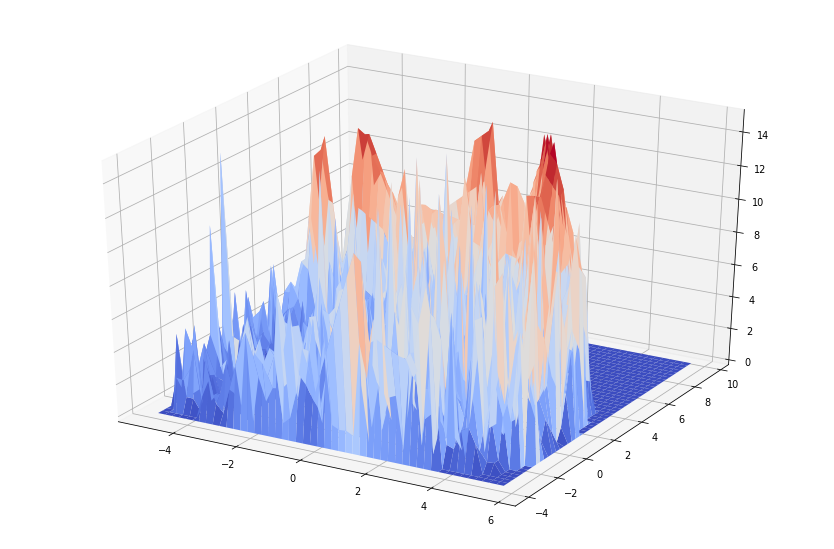

In [111]:
raw = np.load('new_data.npy').astype(np.float)
print(np.any(np.isnan(raw)))
print(np.all(np.isfinite(raw)))
x = raw[:,1:53]
y = raw[:,-1].reshape((-1,1))
print(x.shape)
print(y.shape)

y = (y/60).astype(int)
y[y>15]=15
y.astype(np.int32)

def normalization(x):
    min_max_scaler = preprocessing.MinMaxScaler()
    #x_scaled_01 = min_max_scaler.fit_transform(x)
    x_scaled_std = preprocessing.scale(x)
    return x_scaled_std

def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

#x_scaled_std = x
x_scaled_std = normalization(x)
x_scaled_std_o,y_o = unison_shuffled_copies(x_scaled_std,y)

precentage = 0.8
total_generate = x_scaled_std_o.shape[0]
x_scaled_std = x_scaled_std_o[0:int(total_generate*precentage)]
y = y_o[0:int(total_generate*precentage)]
x_scaled_std_valid = x_scaled_std_o[int(total_generate*precentage):]
y_valid = y_o[int(total_generate*precentage):]

print(x_scaled_std.shape)
print(y.shape)
print(x_scaled_std_valid.shape)
print(y_valid.shape)
def pca(data,component_ = 2):
    pca = PCA(n_components=component_)
    pca.fit(data)
    trans = pca.transform(data)
    print("total variance explained: ")
    total = 0
    for each in pca.explained_variance_ratio_:
        total += each
    print(total)
    return trans

def three_d_viz(trans,tat,way):
    x = trans[:,0].squeeze()
    y = trans[:,1].squeeze()
    z = tat.squeeze()
    
    #z[ z > 1 ] = 1
    #z[ z < 0 ] = 0

    
    xi = np.linspace(min(x), max(x))
    yi = np.linspace(min(y), max(y))
    Xg, Yg = np.meshgrid(xi, yi)
    Zg = griddata(trans, z, (Xg, Yg), method='linear')
    Zg[np.isnan(Zg)]=0
    fig = plt.figure(figsize=(15, 10), dpi= 70)
    ax = fig.gca(projection='3d')
    #surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,linewidth=0, antialiased=False)
    #ax.plot_surface(x,y,z)
    #ax.plot_wireframe(x, y, z, rstride=10, cstride=10)
    if(way=='s'):
        ax.plot_surface(Xg, Yg, Zg,cmap=cm.coolwarm)
    elif(way=='w'):
        ax.plot_wireframe(Xg, Yg, Zg)
    #ax.scatter(x,y,z,c=z)
    #ax.set_zlim3d(0,1200)
    plt.show()

pcaed_data = pca(x_scaled_std)
three_d_viz(pcaed_data,y,'s')


In [139]:
class Model(object):
    def __init__(self):
        self.input = tf.placeholder(tf.float32,shape=[None,52],name='input')
        self.label = tf.placeholder(tf.int32,shape=[None,1],name='label')
        self.global_step = tf.Variable(0, name='global_step',trainable=False)
        self.istraining = tf.placeholder(tf.bool,name='istraining')
        self.keep_probability = tf.placeholder(tf.float32, name="keep_probabilty")
        
    def dense(self,x, size, scope):
        return tf.contrib.layers.fully_connected(x, size, 
                                                 activation_fn=None,
                                                 scope=scope)

    def dense_batch_relu(self,x, size, phase,keep_prob, scope):
        with tf.variable_scope(scope):
            h1 = tf.contrib.layers.fully_connected(x, size, 
                                                   activation_fn=None,
                                                   scope='dense')
            h2 = tf.contrib.layers.batch_norm(h1, 
                                              center=True, scale=False, 
                                              is_training=phase,
                                              updates_collections=None,
                                              zero_debias_moving_mean=True,
                                              scope='bn')
            raw = tf.nn.relu(h1, 'relu')
            out = tf.nn.dropout(raw, keep_prob=keep_prob)
            return out
        
    def inference(self):
        #dense_out = self.denselayer_with_dropout(self.input,1,1)
        #return dense_out
        h1 = self.dense_batch_relu(self.input, 200,self.istraining,self.keep_probability,'layer1')
        h2 = self.dense_batch_relu(h1, 200, self.istraining,self.keep_probability,'layer2')
        logits = self.dense(h1, 15, 'logits')
        return logits
    
    def build_optimizer(self,loss_val,trainable_var,learning_rate):
        optimizer = tf.train.AdamOptimizer(learning_rate) 
        grads = optimizer.compute_gradients(loss_val, var_list=trainable_var)
        return optimizer.apply_gradients(grads,global_step=self.global_step)
        
    def build_train(self,learning_rate):
        raw_output = self.inference()
        onehoted = tf.one_hot(self.label,15)
        #rawloss = tf.losses.absolute_difference(self.label,raw_output)
        #rawloss = tf.losses.mean_squared_error(self.label,raw_output)
        #loss = tf.reduce_mean(rawloss)
        rawloss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=onehoted, logits=raw_output)
        loss = tf.reduce_mean(rawloss)
        trainable_var = tf.trainable_variables()
        train_op = self.build_optimizer(loss,trainable_var,learning_rate)
        return train_op,loss,raw_output
    
    def before_session_initialization(self,learning_rate):
        self.train_op,self.loss_op, self.raw_out = self.build_train(
            learning_rate=learning_rate)
        
    def after_session_initialization(self,sess):
        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())
        self.train_writer = tf.summary.FileWriter('./graph/', sess.graph)
        
    def train(self,sess,data,label,total_epoch,valid_step,data_valid,label_valid):
        loss_history = []
        valid_loss_history = []
        
        for j in range(total_epoch):
            sys.stdout.write(
                '\r>> training process: {}%'.format(100.0*j/total_epoch)
            )
            sys.stdout.flush()
            
            batch_data = data
            batch_label = label
            feed_dict = {self.input: batch_data, self.label: batch_label,self.istraining:True,self.keep_probability:0.8}
            _, train_loss,out= sess.run([self.train_op,self.loss_op,self.raw_out], feed_dict=feed_dict)

            loss_history.append(train_loss)
            if(j%valid_step==0):
                feed_dict = {self.input: data_valid, self.label: label_valid,self.istraining:False,self.keep_probability:1.0}
                test_loss= sess.run([self.loss_op], feed_dict=feed_dict)
                valid_loss_history.append(test_loss)
                
        #print("final_loss",train_loss)
        return loss_history,valid_loss_history
            
    def test(self,sess,data):
        feed_dict = {self.input: data,self.istraining:False,self.keep_probability:1.0}
        out= sess.run([self.raw_out], feed_dict=feed_dict)
        return out
    
    def test_loss(self,sess,data,label):
        feed_dict = {self.input: data,self.label: label, self.istraining:False,self.keep_probability:1.0}
        test_loss= sess.run([self.loss_op], feed_dict=feed_dict)
        return test_loss
    
    def vb (self,sess):
        print(sess.run(self.w))
        print(sess.run(self.b))
        
total_e = 5000
valid_step = 10
tf.reset_default_graph()
model = Model()
model.before_session_initialization(learning_rate=5e-4)
sess = tf.InteractiveSession()
model.after_session_initialization(sess)
loss_hist,valid_loss_history = model.train(sess,x_scaled_std,y,total_e,valid_step,
                                           x_scaled_std_valid,y_valid)
out = model.test(sess,x_scaled_std_valid)
train_out = model.test(sess,x_scaled_std)
test_loss = model.test_loss(sess,x_scaled_std_valid,y_valid)
sess.close()

print("training complete")

>> training process: 99.98%training complete


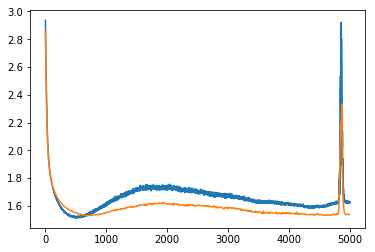

1.5404223


In [140]:
#print(loss_hist)
plt.plot(range(total_e),loss_hist)
plt.plot(range(0,total_e,10),valid_loss_history)
plt.show()
print(test_loss[0])

In [141]:
a_out = out[0]
diff = 0
total = 1.0

for i in range(a_out.shape[0]):
    pred = np.argmax(a_out[i])
    ground = y_valid[i]
    if(pred == ground):
        diff += 1
    total += 1.0

print(diff)
print(total)
print(diff/float(total))

1720
4606.0
0.373425966131


(18416, 1)


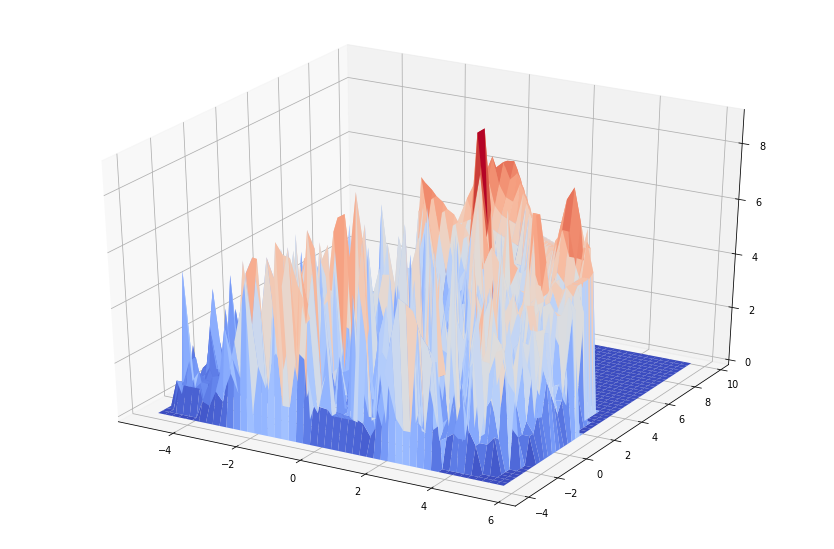

In [137]:
outclass=np.argmax(train_out[0], axis=1).reshape((-1,1))
print(outclass.shape)
three_d_viz(pcaed_data,outclass,'s')

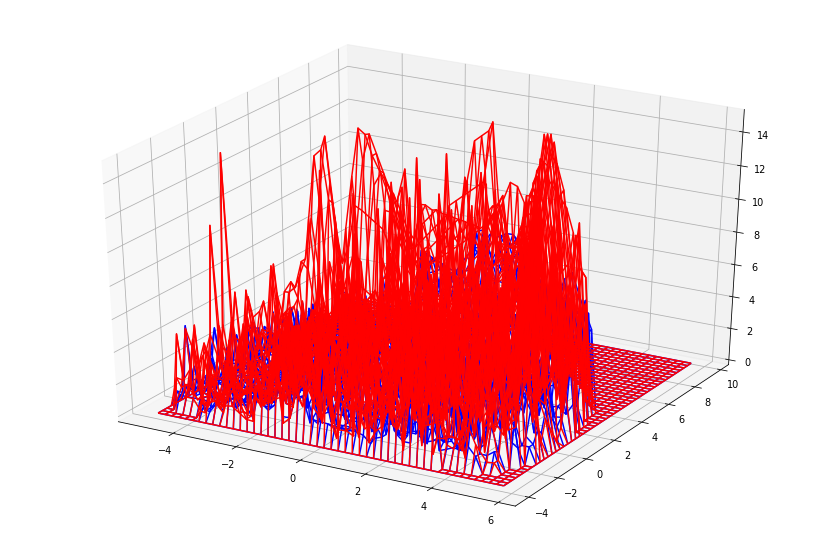

In [138]:
def scatter_diff(xy,z1,z2):
    x = xy[:,0].squeeze()
    y = xy[:,1].squeeze()
    z1 = z1.squeeze()
    z2 = z2.squeeze()
    #fig = plt.figure(figsize=(15, 10), dpi= 70)
    #ax = fig.gca(projection='3d')
    #ax.scatter(x,y,z1,color='r',marker='o')
    #ax.scatter(x,y,z2,color='b',marker='^')
    
    xi = np.linspace(min(x), max(x))
    yi = np.linspace(min(y), max(y))
    Xg, Yg = np.meshgrid(xi, yi)
    Zg1 = griddata(xy, z1, (Xg, Yg), method='linear')
    Zg1[np.isnan(Zg1)]=0
    Zg2 = griddata(xy, z2, (Xg, Yg), method='linear')
    Zg2[np.isnan(Zg2)]=0
    
    fig = plt.figure(figsize=(15, 10), dpi= 70)
    ax = fig.gca(projection='3d')
    
    ax.plot_wireframe(Xg, Yg, Zg2,color="blue")
    ax.plot_wireframe(Xg, Yg, Zg1,color="red")
    #ax.plot_surface(Xg, Yg, Zg1,cmap=cm.coolwarm)
    
    #ax.scatter(x,y,z,c=z)
    plt.show()
    
scatter_diff(pcaed_data,y,np.array(outclass))